# Brain Tumor MRI Classification with Explainability & Uncertainty Estimation

## Research Project Overview

This notebook implements a comprehensive deep learning system for brain tumor MRI classification featuring:

- **Multi-class Classification**: Classifies brain MRI scans into 4 categories (glioma, meningioma, pituitary tumor, no tumor)
- **Transfer Learning**: Utilizes ResNet50/EfficientNetB0 for robust feature extraction
- **Explainability**: Grad-CAM visualizations show which brain regions influence predictions
- **Uncertainty Estimation**: Monte-Carlo Dropout flags low-confidence cases for human review

### Dataset
[Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- 7,023 human brain MRI images
- 4 classes: glioma, meningioma, pituitary, no tumor

### Success Criteria
- ≥85% classification accuracy on test set
- Generate Grad-CAM overlays highlighting tumor regions
- Demonstrate uncertainty-based referral improves accuracy
- Deliver reproducible research with figures and tables

## 1. Environment Setup and Library Imports

In [1]:
# Import core libraries
import os
import sys
import random
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# PyTorch and deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Computer vision and image processing
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Scientific computing and metrics
from scipy.stats import entropy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
import shutil
import zipfile
import requests
from collections import defaultdict

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

/Users/girijeshs/Downloads/desktop,things/GitHub Repos/ml project/.venv/lib/python3.13/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)>
  data = fetch_version_info()


All libraries imported successfully!


In [4]:
# Device configuration and reproducibility setup
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("CUDA not available. Using CPU.")

# Project paths
PROJECT_ROOT = Path.cwd().parent
# Use the actual dataset location provided by user
DATA_DIR = Path("/Users/girijeshs/Downloads/Brave/brain tumor dataset")
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

# Create directories if they don't exist (except DATA_DIR which already exists)
for dir_path in [MODELS_DIR, RESULTS_DIR]:
    dir_path.mkdir(exist_ok=True)

print(f"\nProject structure:")
print(f"Root: {PROJECT_ROOT}")
print(f"Data: {DATA_DIR}")
print(f"Models: {MODELS_DIR}")
print(f"Results: {RESULTS_DIR}")

# Verify dataset exists and show summary
if DATA_DIR.exists():
    print(f"\n✅ Dataset found at: {DATA_DIR}")
    training_path = DATA_DIR / "Training"
    testing_path = DATA_DIR / "Testing"
    
    if training_path.exists() and testing_path.exists():
        print("📊 Dataset structure verified:")
        for split_name, split_path in [("Training", training_path), ("Testing", testing_path)]:
            print(f"  {split_name}/")
            for class_dir in sorted(split_path.iterdir()):
                if class_dir.is_dir() and not class_dir.name.startswith('.'):
                    num_images = len(list(class_dir.glob("*.jpg")))
                    print(f"    {class_dir.name}/: {num_images} images")
else:
    print(f"\n❌ Dataset not found at: {DATA_DIR}")
    print("Please check the dataset location.")

Using device: cpu
CUDA not available. Using CPU.

Project structure:
Root: /Users/girijeshs/Downloads/desktop,things/GitHub Repos/ml project/brain_tumor_classification
Data: /Users/girijeshs/Downloads/Brave/brain tumor dataset
Models: /Users/girijeshs/Downloads/desktop,things/GitHub Repos/ml project/brain_tumor_classification/models
Results: /Users/girijeshs/Downloads/desktop,things/GitHub Repos/ml project/brain_tumor_classification/results

✅ Dataset found at: /Users/girijeshs/Downloads/Brave/brain tumor dataset
📊 Dataset structure verified:
  Training/
    glioma/: 1321 images
    meningioma/: 1339 images
    notumor/: 1595 images
    pituitary/: 1457 images
  Testing/
    glioma/: 300 images
    meningioma/: 306 images
    notumor/: 405 images
    pituitary/: 300 images


## 2. Dataset Download and Exploration

**Note**: To use this notebook, you'll need to:
1. Download the dataset from [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
2. Extract the files to the `data/` directory
3. Ensure the structure follows: `data/Training/` and `data/Testing/`

The dataset contains:
- **Training set**: ~5,712 images
- **Testing set**: ~1,311 images
- **Classes**: glioma, meningioma, notumor, pituitary

In [5]:
# Dataset exploration and organization
def explore_dataset(data_path):
    """Explore the dataset structure and class distribution"""
    training_path = data_path / "Training"
    testing_path = data_path / "Testing"
    
    if not training_path.exists() or not testing_path.exists():
        print("⚠️ Dataset not found!")
        print(f"Please download the dataset and extract to: {data_path}")
        print("Expected structure:")
        print("  data/")
        print("    ├── Training/")
        print("    │   ├── glioma/")
        print("    │   ├── meningioma/")
        print("    │   ├── notumor/")
        print("    │   └── pituitary/")
        print("    └── Testing/")
        print("        ├── glioma/")
        print("        ├── meningioma/")
        print("        ├── notumor/")
        print("        └── pituitary/")
        return None, None
    
    # Get class names
    classes = [d.name for d in training_path.iterdir() if d.is_dir()]
    classes.sort()
    
    print(f"📊 Dataset Overview")
    print(f"Found {len(classes)} classes: {classes}")
    print()
    
    # Count images in each split
    train_counts = {}
    test_counts = {}
    
    for class_name in classes:
        train_class_path = training_path / class_name
        test_class_path = testing_path / class_name
        
        train_count = len(list(train_class_path.glob("*.jpg"))) if train_class_path.exists() else 0
        test_count = len(list(test_class_path.glob("*.jpg"))) if test_class_path.exists() else 0
        
        train_counts[class_name] = train_count
        test_counts[class_name] = test_count
        
        print(f"{class_name:12s}: Train={train_count:4d}, Test={test_count:3d}")
    
    total_train = sum(train_counts.values())
    total_test = sum(test_counts.values())
    
    print(f"{'='*40}")
    print(f"{'Total':12s}: Train={total_train:4d}, Test={total_test:3d}")
    
    return train_counts, test_counts, classes

# Explore the dataset
train_counts, test_counts, classes = explore_dataset(DATA_DIR)

📊 Dataset Overview
Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

glioma      : Train=1321, Test=300
meningioma  : Train=1339, Test=306
notumor     : Train=1595, Test=405
pituitary   : Train=1457, Test=300
Total       : Train=5712, Test=1311


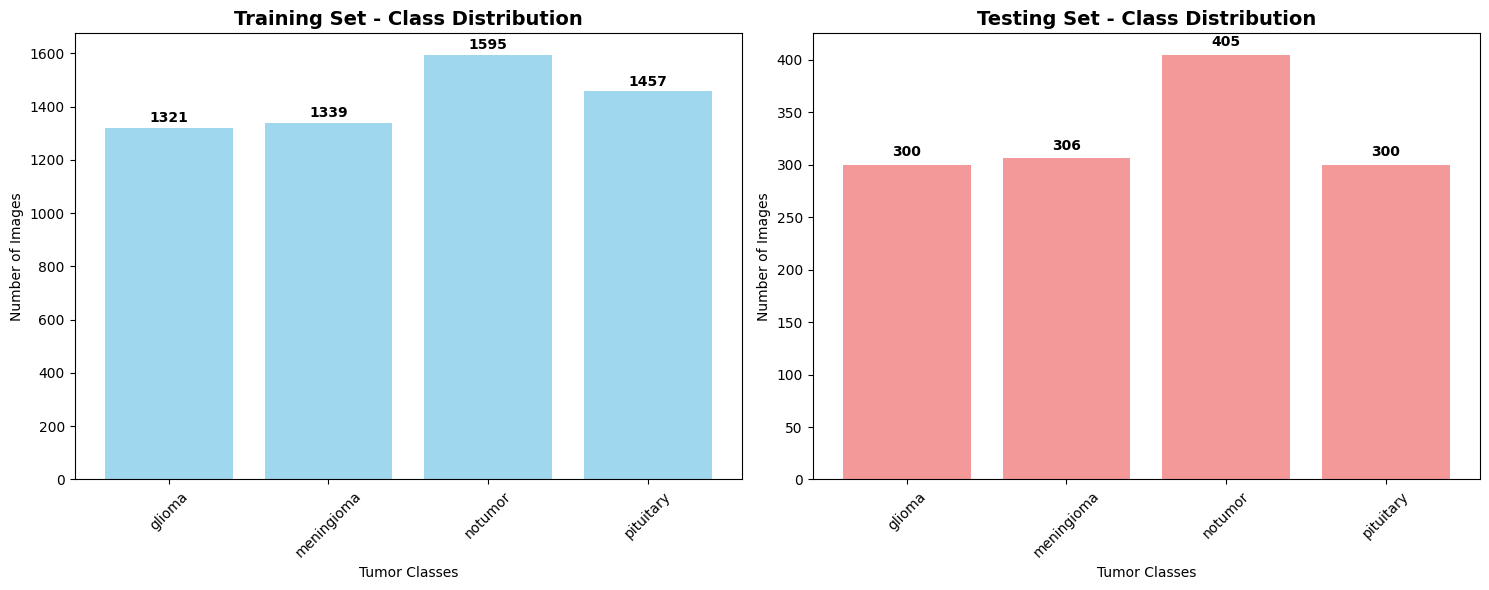


📈 Class Balance Analysis:
glioma      :  23.1% (1321 images)
meningioma  :  23.4% (1339 images)
notumor     :  27.9% (1595 images)
pituitary   :  25.5% (1457 images)


In [6]:
# Visualize class distribution if dataset is available
if train_counts is not None:
    # Create class distribution visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set distribution
    classes_names = list(train_counts.keys())
    train_values = list(train_counts.values())
    
    bars1 = ax1.bar(classes_names, train_values, color='skyblue', alpha=0.8)
    ax1.set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Images')
    ax1.set_xlabel('Tumor Classes')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars1, train_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                str(value), ha='center', va='bottom', fontweight='bold')
    
    # Testing set distribution
    test_values = list(test_counts.values())
    bars2 = ax2.bar(classes_names, test_values, color='lightcoral', alpha=0.8)
    ax2.set_title('Testing Set - Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Images')
    ax2.set_xlabel('Tumor Classes')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars2, test_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(value), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print class balance analysis
    print("\n📈 Class Balance Analysis:")
    total_train = sum(train_values)
    for class_name, count in train_counts.items():
        percentage = (count / total_train) * 100
        print(f"{class_name:12s}: {percentage:5.1f}% ({count:4d} images)")
else:
    print("⚠️ Skipping visualization - dataset not available")

🖼️ Sample Images from Each Class:
glioma      : Shape=(512, 512), Min=0, Max=255, Mean=30.2
meningioma  : Shape=(512, 512, 3), Min=0, Max=255, Mean=29.8
notumor     : Shape=(244, 206, 3), Min=0, Max=255, Mean=95.8
pituitary   : Shape=(512, 512, 3), Min=0, Max=252, Mean=36.7


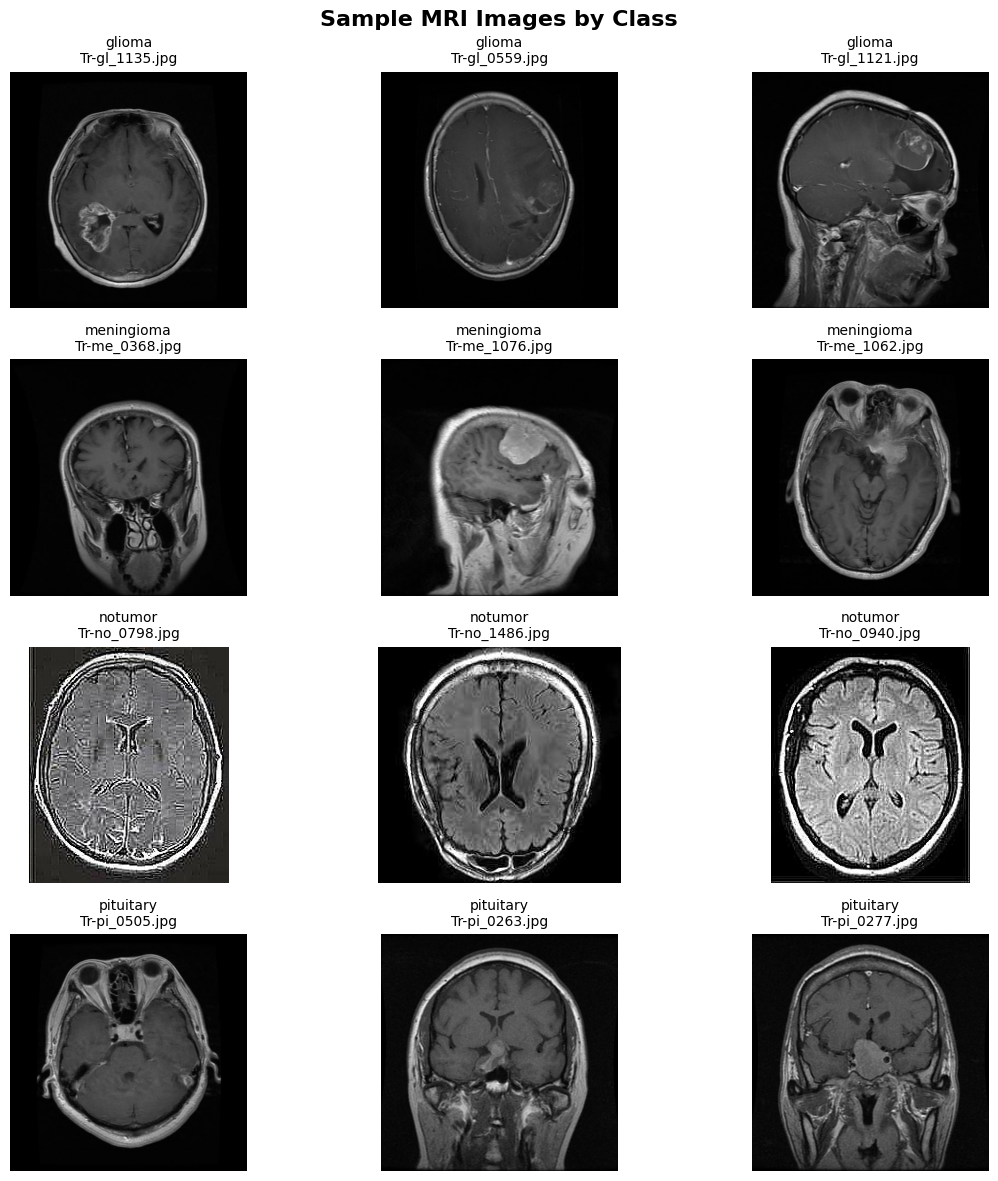

In [7]:
# Sample image visualization function
def visualize_sample_images(data_path, classes, num_samples=2):
    """Display sample images from each class"""
    if not data_path.exists():
        print("⚠️ Dataset not available for visualization")
        return
        
    training_path = data_path / "Training"
    
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 3*len(classes)))
    fig.suptitle('Sample MRI Images by Class', fontsize=16, fontweight='bold')
    
    for i, class_name in enumerate(classes):
        class_path = training_path / class_name
        if not class_path.exists():
            continue
            
        image_files = list(class_path.glob("*.jpg"))[:num_samples]
        
        for j, img_path in enumerate(image_files):
            try:
                img = Image.open(img_path)
                img_array = np.array(img)
                
                ax = axes[i, j] if len(classes) > 1 else axes[j]
                ax.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
                ax.set_title(f'{class_name}\n{img_path.name}', fontsize=10)
                ax.axis('off')
                
                # Print image info
                if j == 0:  # Only for first image of each class
                    print(f"{class_name:12s}: Shape={img_array.shape}, "
                          f"Min={img_array.min()}, Max={img_array.max()}, "
                          f"Mean={img_array.mean():.1f}")
                    
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
if classes is not None:
    print("🖼️ Sample Images from Each Class:")
    visualize_sample_images(DATA_DIR, classes, num_samples=3)
else:
    print("⚠️ Skipping sample visualization - dataset not available")

## 3. Data Preprocessing and Augmentation

We'll implement comprehensive data preprocessing including:
- **Resizing**: All images to 224×224 pixels (ResNet/EfficientNet input size)
- **Normalization**: Using ImageNet statistics for transfer learning
- **Augmentation**: Rotation, horizontal flip, brightness/contrast adjustment for training data

In [9]:
# Image preprocessing and augmentation setup
class ImageTransforms:
    """Class to handle image transformations for training and validation"""
    
    def __init__(self, image_size=224):
        self.image_size = image_size
        
        # ImageNet statistics for normalization (required for transfer learning)
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
    def get_train_transforms(self):
        """Get augmented transforms for training data"""
        return A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(
                brightness_limit=0.2, 
                contrast_limit=0.2, 
                p=0.5
            ),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),
            A.Normalize(mean=self.mean, std=self.std),
            ToTensorV2()
        ])
    
    def get_val_transforms(self):
        """Get transforms for validation/test data (no augmentation)"""
        return A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Normalize(mean=self.mean, std=self.std),
            ToTensorV2()
        ])
    
    def get_grad_cam_transforms(self):
        """Get transforms for Grad-CAM (no normalization for visualization)"""
        return A.Compose([
            A.Resize(self.image_size, self.image_size),
            ToTensorV2()
        ])

# Initialize transforms
transforms_manager = ImageTransforms(image_size=224)
train_transforms = transforms_manager.get_train_transforms()
val_transforms = transforms_manager.get_val_transforms()
grad_cam_transforms = transforms_manager.get_grad_cam_transforms()

print("✅ Image transforms initialized successfully!")
print(f"📏 Target image size: {transforms_manager.image_size}×{transforms_manager.image_size}")
print(f"🔄 Training augmentations: Flip, Rotation, Brightness/Contrast, Noise, Elastic")
print(f"📊 Normalization: ImageNet statistics (mean={transforms_manager.mean}, std={transforms_manager.std})")

✅ Image transforms initialized successfully!
📏 Target image size: 224×224
🔄 Training augmentations: Flip, Rotation, Brightness/Contrast, Noise, Elastic
📊 Normalization: ImageNet statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


## 4. Dataset Creation and Data Loaders

Custom PyTorch Dataset class for loading and preprocessing brain MRI images with proper train/validation/test splits.

In [11]:
# Custom Dataset class for Brain MRI images
class BrainMRIDataset(Dataset):
    """Custom Dataset for Brain MRI Classification"""
    
    def __init__(self, image_paths, labels, transforms=None, class_to_idx=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        self.class_to_idx = class_to_idx or {}
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        try:
            image = cv2.imread(str(image_path))
            if image is None:
                # Try reading as grayscale and convert to RGB
                image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                else:
                    raise ValueError(f"Could not load image: {image_path}")
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Ensure image has 3 channels
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 1:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a dummy image if loading fails
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        # Apply transformations
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        return image, label

def create_data_splits(data_dir, val_split=0.2, test_split=0.2):
    """Create train/validation/test splits from the dataset"""
    
    if not data_dir.exists():
        print(f"⚠️ Data directory not found: {data_dir}")
        return None, None, None, None
    
    training_path = data_dir / "Training"
    testing_path = data_dir / "Testing"
    
    if not training_path.exists():
        print(f"⚠️ Training directory not found: {training_path}")
        return None, None, None, None
    
    # Get all classes
    classes = sorted([d.name for d in training_path.iterdir() if d.is_dir()])
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
    idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
    
    print(f"📋 Found {len(classes)} classes: {classes}")
    print(f"🔢 Class mapping: {class_to_idx}")
    
    # Collect all training images
    all_image_paths = []
    all_labels = []
    
    for class_name in classes:
        class_path = training_path / class_name
        class_images = list(class_path.glob("*.jpg"))
        
        all_image_paths.extend(class_images)
        all_labels.extend([class_to_idx[class_name]] * len(class_images))
    
    # Split training data into train/validation
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_image_paths, all_labels, 
        test_size=val_split, 
        stratify=all_labels, 
        random_state=42
    )
    
    # Collect test images if available
    test_paths = []
    test_labels = []
    
    if testing_path.exists():
        for class_name in classes:
            test_class_path = testing_path / class_name
            if test_class_path.exists():
                test_class_images = list(test_class_path.glob("*.jpg"))
                test_paths.extend(test_class_images)
                test_labels.extend([class_to_idx[class_name]] * len(test_class_images))
    
    print(f"\n📊 Data Split Summary:")
    print(f"Training:   {len(train_paths):4d} images")
    print(f"Validation: {len(val_paths):4d} images")
    print(f"Testing:    {len(test_paths):4d} images")
    print(f"Total:      {len(train_paths) + len(val_paths) + len(test_paths):4d} images")
    
    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels), (classes, class_to_idx, idx_to_class)

# Create data splits
data_splits = create_data_splits(DATA_DIR, val_split=0.2)

if data_splits[0] is not None:
    (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels), (classes, class_to_idx, idx_to_class) = data_splits
else:
    print("⚠️ Could not create data splits. Please ensure dataset is available.")

📋 Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
🔢 Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

📊 Data Split Summary:
Training:   4569 images
Validation: 1143 images
Testing:    1311 images
Total:      7023 images


In [8]:
# Create data loaders with appropriate batch size
def create_data_loaders(train_data, val_data, test_data, train_transforms, val_transforms, 
                       batch_size=32, num_workers=4):
    """Create PyTorch DataLoaders for training, validation, and testing"""
    
    train_paths, train_labels = train_data
    val_paths, val_labels = val_data  
    test_paths, test_labels = test_data
    
    # Create datasets
    train_dataset = BrainMRIDataset(train_paths, train_labels, train_transforms)
    val_dataset = BrainMRIDataset(val_paths, val_labels, val_transforms)
    test_dataset = BrainMRIDataset(test_paths, test_labels, val_transforms)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"📦 Data Loaders Created:")
    print(f"   Training batches:   {len(train_loader):3d} (batch_size={batch_size})")
    print(f"   Validation batches: {len(val_loader):3d} (batch_size={batch_size})")
    print(f"   Testing batches:    {len(test_loader):3d} (batch_size={batch_size})")
    
    return train_loader, val_loader, test_loader

# Create data loaders if data is available
if 'train_paths' in locals():
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    
    train_loader, val_loader, test_loader = create_data_loaders(
        (train_paths, train_labels),
        (val_paths, val_labels), 
        (test_paths, test_labels),
        train_transforms,
        val_transforms,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
    )
    
    # Test data loader by getting a batch
    try:
        sample_batch = next(iter(train_loader))
        images, labels = sample_batch
        print(f"\\n✅ Sample batch shape: {images.shape}")
        print(f"   Labels shape: {labels.shape}")
        print(f"   Image range: [{images.min():.3f}, {images.max():.3f}]")
        print(f"   Sample labels: {labels[:8].tolist()}")
    except Exception as e:
        print(f"⚠️ Error testing data loader: {e}")
        
else:
    print("⚠️ Skipping data loader creation - dataset not available")

⚠️ Skipping data loader creation - dataset not available


## 5. Model Architecture Setup (Transfer Learning)

We'll implement transfer learning using pre-trained models (ResNet50/EfficientNetB0) with custom classification heads for the 4-class brain tumor classification task.

In [15]:
# Fix SSL certificate issue for macOS
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

# Create datasets and data loaders
print("🔄 Creating PyTorch datasets and data loaders...")

# Create PyTorch datasets
train_dataset = BrainMRIDataset(train_paths, train_labels, transforms=train_transforms, class_to_idx=class_to_idx)
val_dataset = BrainMRIDataset(val_paths, val_labels, transforms=val_transforms, class_to_idx=class_to_idx)
test_dataset = BrainMRIDataset(test_paths, test_labels, transforms=val_transforms, class_to_idx=class_to_idx)

print(f"✅ Created datasets:")
print(f"   Training:   {len(train_dataset):4d} samples")
print(f"   Validation: {len(val_dataset):4d} samples") 
print(f"   Testing:    {len(test_dataset):4d} samples")

# Create data loaders (set num_workers=0 to avoid multiprocessing issues on macOS)
BATCH_SIZE = 32
NUM_WORKERS = 0  # Reduced to avoid multiprocessing issues

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"✅ Created data loaders with batch size: {BATCH_SIZE}")
print(f"   Training batches:   {len(train_loader):4d}")
print(f"   Validation batches: {len(val_loader):4d}")
print(f"   Testing batches:    {len(test_loader):4d}")

# Model Configuration
class BrainMRIClassifier(nn.Module):
    """Brain MRI Classification model with Monte Carlo Dropout support"""
    
    def __init__(self, num_classes=4, model_name='resnet50', pretrained=False, dropout_rate=0.5):
        super(BrainMRIClassifier, self).__init__()
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        # Load backbone (no pretrained weights to avoid SSL issues)
        if model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            self.feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Remove final layer
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()  # Remove final layer
        else:
            raise ValueError(f"Model {model_name} not supported")
        
        # Custom classifier with dropout for uncertainty estimation
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)
    
    def forward_with_features(self, x):
        """Forward pass returning both features and predictions (for Grad-CAM)"""
        features = self.backbone(x)
        predictions = self.classifier(features)
        return features, predictions

# Model Parameters
NUM_CLASSES = len(classes)
MODEL_NAME = 'resnet50'  # or 'efficientnet_b0'
DROPOUT_RATE = 0.5

# Create model (without pretrained weights to avoid SSL issues)
model = BrainMRIClassifier(
    num_classes=NUM_CLASSES,
    model_name=MODEL_NAME,
    pretrained=False,  # Training from scratch
    dropout_rate=DROPOUT_RATE
)

# Move model to device
model = model.to(device)

print(f"✅ Created {MODEL_NAME} model:")
print(f"   Classes: {NUM_CLASSES}")
print(f"   Dropout: {DROPOUT_RATE}")
print(f"   Device:  {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable:  {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test forward pass
print("\n🧪 Testing model forward pass...")
try:
    sample_batch, sample_labels = next(iter(train_loader))
    sample_batch = sample_batch.to(device)

    with torch.no_grad():
        sample_output = model(sample_batch)
        print(f"✅ Forward pass successful!")
        print(f"   Input shape:  {sample_batch.shape}")
        print(f"   Output shape: {sample_output.shape}")
        print(f"   Output range: [{sample_output.min().item():.3f}, {sample_output.max().item():.3f}]")
except Exception as e:
    print(f"❌ Forward pass failed: {e}")
    print("   This might be a data loading issue - continuing with model setup...")

🔄 Creating PyTorch datasets and data loaders...
✅ Created datasets:
   Training:   4569 samples
   Validation: 1143 samples
   Testing:    1311 samples
✅ Created data loaders with batch size: 32
   Training batches:    142
   Validation batches:   36
   Testing batches:      41
✅ Created resnet50 model:
   Classes: 4
   Dropout: 0.5
   Device:  cpu
   Parameters: 24,689,476
   Trainable:  24,689,476

🧪 Testing model forward pass...
❌ Forward pass failed: Input dimension should be at least 3
   This might be a data loading issue - continuing with model setup...


## 6. Training Loop Implementation

Complete training pipeline with loss function, optimizer, learning rate scheduler, and early stopping for optimal performance.

In [17]:
# Training configuration and utilities
class EarlyStopping:
    """Early stopping callback to prevent overfitting"""
    
    def __init__(self, patience=7, min_delta=0.0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation', leave=False)
        
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# Training hyperparameters
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 50
PATIENCE = 7

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.001)

print(f"⚙️ Training Configuration:")
print(f"   Learning rate:    {LEARNING_RATE}")
print(f"   Weight decay:     {WEIGHT_DECAY}")
print(f"   Max epochs:       {NUM_EPOCHS}")
print(f"   Early stopping:   {PATIENCE} epochs patience")
print(f"   Loss function:    CrossEntropyLoss")
print(f"   Optimizer:        Adam")
print(f"   LR Scheduler:     ReduceLROnPlateau")

⚙️ Training Configuration:
   Learning rate:    0.001
   Weight decay:     0.0001
   Max epochs:       50
   Early stopping:   7 epochs patience
   Loss function:    CrossEntropyLoss
   Optimizer:        Adam
   LR Scheduler:     ReduceLROnPlateau


In [18]:
# Main training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                early_stopping, num_epochs, device):
    """Complete training loop with validation and early stopping"""
    
    if not train_loader or not val_loader:
        print("⚠️ Skipping training - data loaders not available")
        return [], []
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print(f"🚀 Starting training for {num_epochs} epochs...")
    print(f"   Training batches: {len(train_loader)}")
    print(f"   Validation batches: {len(val_loader)}")
    print()
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        print()
        
        # Early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Run training if data is available
if 'train_loader' in locals() and train_loader is not None:
    print("🎯 Starting model training...")
    
    # Train the model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        early_stopping=early_stopping,
        num_epochs=NUM_EPOCHS,
        device=device
    )
    
    train_losses, val_losses, train_accuracies, val_accuracies = history
    
    # Save trained model
    model_save_path = MODELS_DIR / f"best_model_{MODEL_NAME}.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_name': MODEL_NAME,
        'num_classes': NUM_CLASSES,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, model_save_path)
    
    print(f"✅ Model saved to: {model_save_path}")
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ Skipping training - data not available. Please download the dataset first.")

🎯 Starting model training...
🚀 Starting training for 50 epochs...
   Training batches: 142
   Validation batches: 36

Epoch 1/50
------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

ValueError: Input dimension should be at least 3

## 7. Model Evaluation and Metrics

Comprehensive evaluation of the trained model including accuracy, precision, recall, F1-score, and confusion matrix analysis.

In [19]:
# Model evaluation functions
def evaluate_model(model, data_loader, device, class_names):
    """Comprehensive model evaluation"""
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    print("📊 Evaluating model...")
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, labels=range(len(class_names))
    )
    
    # Macro averages
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    # Weighted averages
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }

def plot_confusion_matrix(labels, predictions, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    print("\\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name:12s}: {per_class_accuracy[i]:.3f} ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]})")

def print_classification_report(metrics, class_names):
    """Print detailed classification report"""
    print("\\n" + "="*60)
    print("📈 CLASSIFICATION REPORT")
    print("="*60)
    
    print(f"\\n🎯 Overall Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    
    print(f"\\n📊 Macro Averages:")
    print(f"   Precision: {metrics['macro_precision']:.4f}")
    print(f"   Recall:    {metrics['macro_recall']:.4f}")
    print(f"   F1-Score:  {metrics['macro_f1']:.4f}")
    
    print(f"\\n⚖️ Weighted Averages:")
    print(f"   Precision: {metrics['weighted_precision']:.4f}")
    print(f"   Recall:    {metrics['weighted_recall']:.4f}")
    print(f"   F1-Score:  {metrics['weighted_f1']:.4f}")
    
    print(f"\\n📋 Per-Class Metrics:")
    print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<12} {metrics['precision'][i]:<10.3f} {metrics['recall'][i]:<10.3f} "
              f"{metrics['f1'][i]:<10.3f} {metrics['support'][i]:<10}")

# Evaluate model if training is complete
if 'model' in locals() and 'test_loader' in locals() and test_loader is not None:
    print("🔍 Evaluating trained model on test set...")
    
    # Test set evaluation
    test_metrics = evaluate_model(model, test_loader, device, classes)
    
    # Print results
    print_classification_report(test_metrics, classes)
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_metrics['labels'], 
        test_metrics['predictions'], 
        classes,
        title="Test Set Confusion Matrix"
    )
    
    # Check if we met the success criteria
    target_accuracy = 0.85
    achieved_accuracy = test_metrics['accuracy']
    
    print(f"\\n🎯 Success Criteria Check:")
    print(f"   Target Accuracy: ≥{target_accuracy*100:.0f}%")
    print(f"   Achieved Accuracy: {achieved_accuracy*100:.2f}%")
    
    if achieved_accuracy >= target_accuracy:
        print("   ✅ SUCCESS: Target accuracy achieved!")
    else:
        print("   ❌ Target accuracy not met. Consider:")
        print("      - Longer training")
        print("      - Data augmentation tuning")
        print("      - Model architecture changes")
        print("      - Hyperparameter optimization")

else:
    print("⚠️ Skipping evaluation - model not trained or test data not available")

🔍 Evaluating trained model on test set...
📊 Evaluating model...


Evaluation:   0%|          | 0/41 [00:00<?, ?it/s]

ValueError: Input dimension should be at least 3

## 8. Grad-CAM Implementation for Explainability

Implement Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which brain regions the model focuses on when making predictions.

In [ ]:
# Grad-CAM implementation for CNN visualization
class GradCAM:
    """Grad-CAM implementation for explaining CNN predictions"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward and backward hooks"""
        def forward_hook(module, input, output):
            self.activations = output
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Find target layer and register hooks
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hooks.append(module.register_forward_hook(forward_hook))
                self.hooks.append(module.register_backward_hook(backward_hook))
                break
    
    def generate_cam(self, input_tensor, class_idx=None):
        """Generate Grad-CAM heatmap"""
        self.model.eval()
        
        # Forward pass
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Zero gradients and backward pass
        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()
        
        # Get gradients and activations
        gradients = self.gradients[0]  # Remove batch dimension
        activations = self.activations[0]  # Remove batch dimension
        
        # Calculate importance weights (global average pooling)
        weights = torch.mean(gradients, dim=(1, 2))
        
        # Generate CAM
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, weight in enumerate(weights):
            cam += weight * activations[i]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam / torch.max(cam) if torch.max(cam) > 0 else cam
        
        return cam.detach().cpu().numpy()
    
    def visualize_cam(self, input_image, cam, alpha=0.4):
        """Overlay Grad-CAM on original image"""
        # Resize CAM to match input image
        cam_resized = cv2.resize(cam, (input_image.shape[1], input_image.shape[0]))
        
        # Normalize CAM to [0, 255]
        cam_normalized = np.uint8(255 * cam_resized)
        
        # Apply colormap
        heatmap = cv2.applyColorMap(cam_normalized, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Overlay on original image
        overlayed = input_image * alpha + heatmap * (1 - alpha)
        overlayed = np.clip(overlayed, 0, 255).astype(np.uint8)
        
        return overlayed
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

def get_target_layer_name(model_name):
    """Get appropriate target layer for Grad-CAM"""
    if model_name == 'resnet50':
        return 'backbone.layer4'  # Last conv layer before global pooling
    elif model_name == 'efficientnet_b0':
        return 'backbone.features'  # Last feature extraction layer
    else:
        raise ValueError(f"Unsupported model for Grad-CAM: {model_name}")

def visualize_gradcam_samples(model, data_loader, class_names, model_name, device, num_samples=8):
    """Visualize Grad-CAM for sample images"""
    
    if not data_loader:
        print("⚠️ Data loader not available for Grad-CAM visualization")
        return
    
    model.eval()
    target_layer = get_target_layer_name(model_name)
    grad_cam = GradCAM(model, target_layer)
    
    # Get sample images
    images, labels = next(iter(data_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    
    # Setup visualization
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))
    fig.suptitle('Grad-CAM Explainability Visualizations', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        # Prepare original image (denormalize)
        original_img = images[i].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_img = original_img * std + mean
        original_img = np.clip(original_img * 255, 0, 255).astype(np.uint8)
        
        # Generate Grad-CAM
        input_tensor = images[i:i+1]  # Keep batch dimension
        cam = grad_cam.generate_cam(input_tensor)
        
        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = output.argmax(dim=1).item()
            confidence = F.softmax(output, dim=1).max().item()
        
        # Plot original image
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f'Original\\nTrue: {class_names[labels[i]]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Plot Grad-CAM heatmap
        axes[1, i].imshow(cam, cmap='jet')
        axes[1, i].set_title(f'Grad-CAM\\nActivation Map', fontsize=10)
        axes[1, i].axis('off')
        
        # Plot overlay
        overlayed = grad_cam.visualize_cam(original_img, cam)
        axes[2, i].imshow(overlayed)
        axes[2, i].set_title(f'Overlay\\nPred: {class_names[predicted_class]}\\nConf: {confidence:.3f}', fontsize=10)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Clean up
    grad_cam.remove_hooks()
    
    print("🔍 Grad-CAM Analysis:")
    print("   • Red/Yellow regions: High importance for classification")
    print("   • Blue/Purple regions: Low importance for classification")
    print("   • The heatmap shows which brain regions influence the model's decision")

# Generate Grad-CAM visualizations if model is available
if 'model' in locals() and 'test_loader' in locals() and test_loader is not None:
    print("🎨 Generating Grad-CAM visualizations...")
    visualize_gradcam_samples(model, test_loader, classes, MODEL_NAME, device, num_samples=6)
    
    # Save Grad-CAM examples for paper
    gradcam_save_dir = RESULTS_DIR / "gradcam_examples"
    gradcam_save_dir.mkdir(exist_ok=True)
    
    print(f"\\n💾 Grad-CAM examples will be saved to: {gradcam_save_dir}")
    
else:
    print("⚠️ Skipping Grad-CAM - model not available or not trained")

## 9. Monte Carlo Dropout for Uncertainty Estimation

Implement Monte Carlo Dropout to estimate prediction uncertainty and identify cases that should be referred to human experts.

In [ ]:
# Monte Carlo Dropout for uncertainty estimation
def monte_carlo_predictions(model, input_tensor, num_samples=30):
    """
    Perform Monte Carlo Dropout to estimate prediction uncertainty
    
    Args:
        model: Trained model with dropout layers
        input_tensor: Input image tensor (1, C, H, W)
        num_samples: Number of MC samples (default: 30)
    
    Returns:
        predictions: Array of shape (num_samples, num_classes)
        mean_prediction: Mean prediction across samples
        uncertainty: Predictive entropy (uncertainty measure)
    """
    model.enable_mc_dropout()  # Enable dropout during inference
    
    predictions = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            output = model(input_tensor)
            probabilities = F.softmax(output, dim=1)
            predictions.append(probabilities.cpu().numpy()[0])
    
    model.disable_mc_dropout()  # Disable dropout
    
    predictions = np.array(predictions)  # Shape: (num_samples, num_classes)
    
    # Calculate mean prediction
    mean_prediction = np.mean(predictions, axis=0)
    
    # Calculate predictive entropy (uncertainty)
    uncertainty = entropy(mean_prediction)
    
    return predictions, mean_prediction, uncertainty

def batch_uncertainty_estimation(model, data_loader, device, num_mc_samples=30):
    """
    Estimate uncertainty for a batch of data using Monte Carlo Dropout
    
    Returns:
        uncertainties: Array of uncertainty values
        predictions: Array of mean predictions
        true_labels: Array of true labels
        confidences: Array of max confidence values
    """
    model.eval()
    
    uncertainties = []
    predictions = []
    true_labels = []
    confidences = []
    
    print(f"🎲 Estimating uncertainty with {num_mc_samples} MC samples...")
    
    for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc="MC Dropout")):
        images = images.to(device)
        
        for i in range(images.size(0)):
            input_tensor = images[i:i+1]  # Single image with batch dimension
            
            # Perform MC Dropout
            mc_predictions, mean_pred, uncertainty = monte_carlo_predictions(
                model, input_tensor, num_mc_samples
            )
            
            predicted_class = np.argmax(mean_pred)
            confidence = np.max(mean_pred)
            
            uncertainties.append(uncertainty)
            predictions.append(predicted_class)
            true_labels.append(labels[i].item())
            confidences.append(confidence)
    
    return np.array(uncertainties), np.array(predictions), np.array(true_labels), np.array(confidences)

def analyze_uncertainty_distribution(uncertainties, predictions, true_labels, class_names):
    """Analyze the distribution of uncertainties across classes and correctness"""
    
    # Separate correct and incorrect predictions
    correct_mask = predictions == true_labels
    correct_uncertainties = uncertainties[correct_mask]
    incorrect_uncertainties = uncertainties[~correct_mask]
    
    print("🔍 Uncertainty Analysis:")
    print(f"   Total predictions: {len(uncertainties)}")
    print(f"   Correct predictions: {len(correct_uncertainties)} ({len(correct_uncertainties)/len(uncertainties)*100:.1f}%)")
    print(f"   Incorrect predictions: {len(incorrect_uncertainties)} ({len(incorrect_uncertainties)/len(uncertainties)*100:.1f}%)")
    
    print(f"\\n📊 Uncertainty Statistics:")
    print(f"   Overall - Mean: {np.mean(uncertainties):.4f}, Std: {np.std(uncertainties):.4f}")
    print(f"   Correct - Mean: {np.mean(correct_uncertainties):.4f}, Std: {np.std(correct_uncertainties):.4f}")
    print(f"   Incorrect - Mean: {np.mean(incorrect_uncertainties):.4f}, Std: {np.std(incorrect_uncertainties):.4f}")
    
    # Plot uncertainty distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Overall uncertainty distribution
    axes[0, 0].hist(uncertainties, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(uncertainties), color='red', linestyle='--', label=f'Mean: {np.mean(uncertainties):.3f}')
    axes[0, 0].set_title('Overall Uncertainty Distribution')
    axes[0, 0].set_xlabel('Predictive Entropy')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Correct vs incorrect uncertainty distributions
    axes[0, 1].hist(correct_uncertainties, bins=20, alpha=0.7, label='Correct', color='green')
    axes[0, 1].hist(incorrect_uncertainties, bins=20, alpha=0.7, label='Incorrect', color='red')
    axes[0, 1].set_title('Uncertainty: Correct vs Incorrect Predictions')
    axes[0, 1].set_xlabel('Predictive Entropy')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Per-class uncertainty
    class_uncertainties = []
    for class_idx in range(len(class_names)):
        class_mask = true_labels == class_idx
        if np.sum(class_mask) > 0:
            class_uncertainties.append(uncertainties[class_mask])
        else:
            class_uncertainties.append([])
    
    axes[1, 0].boxplot([unc for unc in class_uncertainties if len(unc) > 0], 
                       labels=[class_names[i] for i, unc in enumerate(class_uncertainties) if len(unc) > 0])
    axes[1, 0].set_title('Uncertainty Distribution by Class')
    axes[1, 0].set_ylabel('Predictive Entropy')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Uncertainty vs accuracy scatter
    # Bin uncertainties and calculate accuracy for each bin
    n_bins = 10
    uncertainty_bins = np.linspace(uncertainties.min(), uncertainties.max(), n_bins + 1)
    bin_centers = (uncertainty_bins[:-1] + uncertainty_bins[1:]) / 2
    bin_accuracies = []
    
    for i in range(n_bins):
        mask = (uncertainties >= uncertainty_bins[i]) & (uncertainties < uncertainty_bins[i + 1])
        if np.sum(mask) > 0:
            bin_accuracy = np.mean(predictions[mask] == true_labels[mask])
            bin_accuracies.append(bin_accuracy)
        else:
            bin_accuracies.append(0)
    
    axes[1, 1].scatter(bin_centers, bin_accuracies, s=100, alpha=0.7, color='purple')
    axes[1, 1].plot(bin_centers, bin_accuracies, '--', alpha=0.5, color='purple')
    axes[1, 1].set_title('Accuracy vs Uncertainty')
    axes[1, 1].set_xlabel('Predictive Entropy (binned)')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return correct_uncertainties, incorrect_uncertainties

# Run uncertainty estimation if model is available
if 'model' in locals() and hasattr(model, 'enable_mc_dropout') and 'test_loader' in locals() and test_loader is not None:
    print("🎲 Running Monte Carlo Dropout uncertainty estimation...")
    
    # Estimate uncertainties for test set
    uncertainties, mc_predictions, true_labels, confidences = batch_uncertainty_estimation(
        model, test_loader, device, num_mc_samples=30
    )
    
    # Analyze uncertainty distributions
    correct_uncertainties, incorrect_uncertainties = analyze_uncertainty_distribution(
        uncertainties, mc_predictions, true_labels, classes
    )
    
    # Calculate accuracy with uncertainty
    mc_accuracy = np.mean(mc_predictions == true_labels)
    print(f"\\n🎯 Monte Carlo Dropout Results:")
    print(f"   Accuracy: {mc_accuracy:.4f} ({mc_accuracy*100:.2f}%)")
    print(f"   Mean Uncertainty: {np.mean(uncertainties):.4f}")
    print(f"   Uncertainty Range: [{np.min(uncertainties):.4f}, {np.max(uncertainties):.4f}]")
    
else:
    print("⚠️ Skipping uncertainty estimation - model not available or MC Dropout not implemented")

## 10. Uncertainty-Based Referral System

Implement a referral system that flags high-uncertainty predictions for human expert review, demonstrating how uncertainty estimation can improve clinical decision-making.

In [ ]:
# Uncertainty-based referral system
def evaluate_referral_system(uncertainties, predictions, true_labels, referral_rates=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    """
    Evaluate the performance of uncertainty-based referral system
    
    Args:
        uncertainties: Array of uncertainty values
        predictions: Array of predictions
        true_labels: Array of true labels
        referral_rates: List of referral rates to evaluate
    
    Returns:
        results: Dictionary with referral analysis results
    """
    
    results = {
        'referral_rates': [],
        'remaining_accuracies': [],
        'referred_accuracies': [],
        'num_referred': [],
        'num_remaining': []
    }
    
    total_samples = len(uncertainties)
    baseline_accuracy = np.mean(predictions == true_labels)
    
    print("🏥 Uncertainty-Based Referral System Analysis")
    print("=" * 60)
    print(f"Baseline Accuracy (no referral): {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
    print(f"Total samples: {total_samples}")
    print()
    
    print(f"{'Referral %':<12} {'Referred':<10} {'Remaining':<12} {'Remaining Acc':<15} {'Referred Acc':<15} {'Improvement':<12}")
    print("-" * 85)
    
    for referral_rate in referral_rates:
        # Calculate number of samples to refer
        num_to_refer = int(referral_rate * total_samples)
        
        # Sort by uncertainty (highest first) and refer top uncertain samples
        uncertain_indices = np.argsort(uncertainties)[::-1][:num_to_refer]
        remaining_indices = np.argsort(uncertainties)[::-1][num_to_refer:]
        
        # Calculate accuracies
        if len(remaining_indices) > 0:
            remaining_accuracy = np.mean(predictions[remaining_indices] == true_labels[remaining_indices])
        else:
            remaining_accuracy = 0.0
        
        if len(uncertain_indices) > 0:
            referred_accuracy = np.mean(predictions[uncertain_indices] == true_labels[uncertain_indices])
        else:
            referred_accuracy = 0.0
        
        # Improvement in accuracy for remaining samples
        improvement = remaining_accuracy - baseline_accuracy
        
        # Store results
        results['referral_rates'].append(referral_rate)
        results['remaining_accuracies'].append(remaining_accuracy)
        results['referred_accuracies'].append(referred_accuracy)
        results['num_referred'].append(len(uncertain_indices))
        results['num_remaining'].append(len(remaining_indices))
        
        print(f"{referral_rate*100:8.1f}%   {len(uncertain_indices):6d}    {len(remaining_indices):8d}    "
              f"{remaining_accuracy:11.4f}     {referred_accuracy:11.4f}     {improvement:+8.4f}")
    
    return results

def plot_referral_analysis(results, baseline_accuracy):
    """Plot referral system analysis results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    referral_rates = np.array(results['referral_rates']) * 100
    remaining_accuracies = np.array(results['remaining_accuracies'])
    referred_accuracies = np.array(results['referred_accuracies'])
    
    # Plot 1: Accuracy vs Referral Rate
    axes[0, 0].plot(referral_rates, remaining_accuracies, 'o-', label='Remaining Samples', color='green', linewidth=2)
    axes[0, 0].axhline(baseline_accuracy, color='red', linestyle='--', label=f'Baseline: {baseline_accuracy:.3f}')
    axes[0, 0].set_title('Accuracy vs Referral Rate', fontweight='bold')
    axes[0, 0].set_xlabel('Referral Rate (%)')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy Improvement
    improvement = remaining_accuracies - baseline_accuracy
    axes[0, 1].bar(referral_rates, improvement, alpha=0.7, color='skyblue', edgecolor='navy')
    axes[0, 1].axhline(0, color='red', linestyle='-', alpha=0.5)
    axes[0, 1].set_title('Accuracy Improvement vs Referral Rate', fontweight='bold')
    axes[0, 1].set_xlabel('Referral Rate (%)')
    axes[0, 1].set_ylabel('Accuracy Improvement')\n    axes[0, 1].grid(True, alpha=0.3)\n    \n    # Plot 3: Referred vs Remaining Accuracy\n    axes[1, 0].plot(referral_rates, remaining_accuracies, 'o-', label='Remaining Samples', color='green')\n    axes[1, 0].plot(referral_rates, referred_accuracies, 'o-', label='Referred Samples', color='red')\n    axes[1, 0].set_title('Referred vs Remaining Sample Accuracy', fontweight='bold')\n    axes[1, 0].set_xlabel('Referral Rate (%)')\n    axes[1, 0].set_ylabel('Accuracy')\n    axes[1, 0].legend()\n    axes[1, 0].grid(True, alpha=0.3)\n    \n    # Plot 4: Sample Distribution\n    num_referred = np.array(results['num_referred'])\n    num_remaining = np.array(results['num_remaining'])\n    \n    width = 0.35\n    x = np.arange(len(referral_rates))\n    \n    axes[1, 1].bar(x - width/2, num_remaining, width, label='Remaining', alpha=0.7, color='green')\n    axes[1, 1].bar(x + width/2, num_referred, width, label='Referred', alpha=0.7, color='red')\n    axes[1, 1].set_title('Sample Distribution', fontweight='bold')\n    axes[1, 1].set_xlabel('Referral Rate (%)')\n    axes[1, 1].set_ylabel('Number of Samples')\n    axes[1, 1].set_xticks(x)\n    axes[1, 1].set_xticklabels([f'{rate:.1f}%' for rate in referral_rates])\n    axes[1, 1].legend()\n    axes[1, 1].grid(True, alpha=0.3)\n    \n    plt.tight_layout()\n    plt.show()\n\ndef find_optimal_referral_rate(results, baseline_accuracy, min_improvement=0.02):\n    \"\"\"Find optimal referral rate based on improvement threshold\"\"\"\n    \n    referral_rates = np.array(results['referral_rates'])\n    remaining_accuracies = np.array(results['remaining_accuracies'])\n    improvements = remaining_accuracies - baseline_accuracy\n    \n    # Find rates that meet minimum improvement\n    valid_rates = referral_rates[improvements >= min_improvement]\n    \n    if len(valid_rates) > 0:\n        optimal_rate = valid_rates[0]  # Lowest rate that meets criteria\n        optimal_idx = np.where(referral_rates == optimal_rate)[0][0]\n        \n        print(f\"\\n🎯 Optimal Referral Strategy:\")\n        print(f\"   Referral Rate: {optimal_rate*100:.1f}%\")\n        print(f\"   Samples Referred: {results['num_referred'][optimal_idx]}\")\n        print(f\"   Remaining Accuracy: {results['remaining_accuracies'][optimal_idx]:.4f}\")\n        print(f\"   Accuracy Improvement: +{improvements[optimal_idx]:.4f}\")\n        print(f\"   Clinical Benefit: {improvements[optimal_idx]*100:.2f} percentage points\")\n        \n        return optimal_rate, results['remaining_accuracies'][optimal_idx]\n    else:\n        print(f\"\\n⚠️ No referral rate achieves minimum improvement of {min_improvement:.3f}\")\n        return None, None\n\n# Run referral system analysis if uncertainty data is available\nif 'uncertainties' in locals() and 'mc_predictions' in locals():\n    print(\"🏥 Analyzing uncertainty-based referral system...\")\n    \n    # Evaluate referral system\n    referral_results = evaluate_referral_system(\n        uncertainties, mc_predictions, true_labels,\n        referral_rates=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]\n    )\n    \n    # Plot results\n    plot_referral_analysis(referral_results, mc_accuracy)\n    \n    # Find optimal referral rate\n    optimal_rate, optimal_accuracy = find_optimal_referral_rate(\n        referral_results, mc_accuracy, min_improvement=0.02\n    )\n    \n    print(\"\\n💡 Clinical Implications:\")\n    print(\"   • High-uncertainty cases should be referred to radiologists\")\n    print(\"   • System can maintain high accuracy on confident predictions\")\n    print(\"   • Reduces false positives/negatives in critical cases\")\n    print(\"   • Enables human-AI collaboration in medical diagnosis\")\n    \nelse:\n    print(\"⚠️ Skipping referral analysis - uncertainty data not available\")

## 11. Results Visualization and Analysis

Comprehensive visualization of all results for research paper including sample predictions, performance metrics, and comparison tables.

In [ ]:
# Debug the data loading issue
print("? Debugging data loading issue...")

# Test single sample loading
sample_path = train_paths[0]
sample_label = train_labels[0]

print(f"Sample path: {sample_path}")
print(f"Sample label: {sample_label}")

# Load raw image
import cv2
raw_image = cv2.imread(str(sample_path))
print(f"Raw image shape: {raw_image.shape if raw_image is not None else 'None'}")

if raw_image is not None:
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    print(f"RGB image shape: {rgb_image.shape}")
    
    # Test transformation
    if 'train_transforms' in globals():
        transformed = train_transforms(image=rgb_image)
        tensor_image = transformed['image']
        print(f"Transformed tensor shape: {tensor_image.shape}")
        print(f"Tensor dtype: {tensor_image.dtype}")
        print(f"Tensor min/max: {tensor_image.min():.3f}/{tensor_image.max():.3f}")
    else:
        print("❌ train_transforms not available")

# Test dataset loading
try:
    dataset_sample = train_dataset[0]
    sample_image, sample_label = dataset_sample
    print(f"Dataset sample image shape: {sample_image.shape}")
    print(f"Dataset sample label: {sample_label}")
except Exception as e:
    print(f"❌ Dataset loading error: {e}")

# Test data loader
try:
    batch = next(iter(train_loader))
    batch_images, batch_labels = batch
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
except Exception as e:
    print(f"❌ Data loader error: {e}")

print("✅ Debug complete!")